# Projet d'apprentissage semi-supervisé

__ModIA 2023__

__Etudiants__: Alexandre Personnic, Thi Minh Ha Ho

__Encadrant__: Axel Carlier


<h1 align="center"><font color='#964B00'>Table de matières</font></h1>
<div style="border-radius:10px; border:#DEB887 solid; background-color: #FFFAF0; font-size:100%; text-align:left">


1. [Importation et exploration de données](#1)
   
2. [Set-up de FixMatch](#2)

     * RandAugment 

     * Réseau fourni 

3. [Partie supervisée](#3)

4. [Partie semi-supervisée](#4)

     * [Avec des images aléatoires](#3_1) 
     * [Avec des images uniques](#3_2) 

In [1]:
# Obtenir des informations sur le GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math
import os
import numpy as np
import json
import codecarbon

2023-07-05 22:24:16.296259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 22:24:16.337813: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 22:24:16.338942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 22:24:17.019214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a id="1"></a> <br>
# Importation de données 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser

In [4]:
import imgaug.augmenters as iaa
aug = iaa.RandAugment(n=2, m=9)

def randaugment(img):
  return aug(images=img)

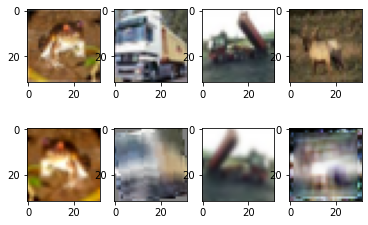

In [5]:
# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = randaugment(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(x_train[i])

  plt.subplot(2,4, i+5)
  plt.imshow(aug_img[i])

## Réseau fourni

Afin d'obtenir des résultats comparables, tout le monde devra utiliser le même réseau, que voici :

In [6]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=(32,32,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    return model

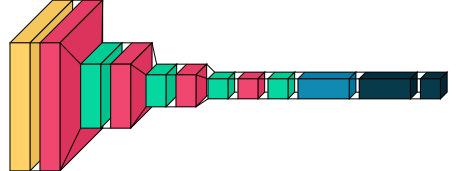

In [7]:
import visualkeras

model = get_model()

visualkeras.layered_view(model, to_file='reseau_fourni.png') # write to disk

visualkeras.layered_view(model)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 32, 32, 3)         7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                        

In [9]:
def generate_dataset(sup_percent=1.0, random_state=None):
    """
    Retourne trois tuples de données et d'étiquettes : supervisé, non supervisé et test.
    
    sup_percent : Pourcentage de données supervisées. Doit être compris entre 0 et 1.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    if sup_percent == 1.0:
        return (x_train, y_train), (None, None), (x_test, y_test)
    x_lab, x_unlab, y_lab, y_unlab = train_test_split(x_train, y_train, train_size=sup_percent, random_state=random_state)
    return (x_lab, y_lab), (x_unlab, y_unlab), (x_test, y_test)

# Partie supervisée <a id="2"></a>

In [10]:
# Tau d'apprentisage initial
eta = 0.03

# Momentum pour SGD
beta = 0.9

# Nombre d'epochs
sup_epoch = 1

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    #brightness_range=(1,1),
    validation_split=0.2)

## Avec x% de données 

On a pris : x $\in$ [0.01, 0.05, 0.1, 1 ]

In [12]:
sup_percent = 1 
(x_train, y_train), _, (x_test, y_test) = generate_dataset(sup_percent)
model = get_model()
model.load_weights("models/supervised/new_100_percent")
model.compile(optimizer="adam",#tf.keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128, subset='training'),
    validation_data=datagen.flow(x_train, y_train, batch_size=32, subset='validation'),
    epochs=1,
    verbose=2)

313/313 - 33s - loss: 1.5999 - accuracy: 0.4161 - val_loss: 1.4914 - val_accuracy: 0.4537 - 33s/epoch - 106ms/step


In [14]:
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 1.4660 - accuracy: 0.4596 - 2s/epoch - 6ms/step


[1.4659613370895386, 0.4596000015735626]

In [15]:
model.save_weights(f"supervised/new_{sup_percent*100}_percent")

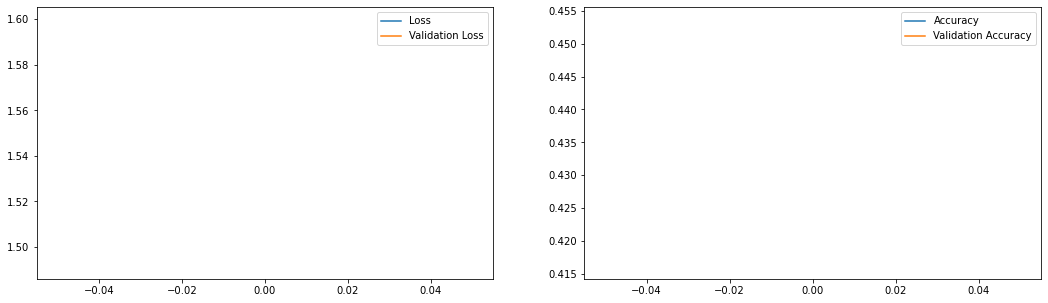

In [16]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss", "Validation Loss"])
plt.subplot(122)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

# Partie semi-supervisée <a id="3"></a>

__Formule de la fonction de pert__


* La perte supervisée: 

\begin{equation}
    L_s=\frac{1}{B} \sum_{i=1}^B H\left(\ell_i, \mathbb{P}_{m}\left(\ell \mid \bm{\alpha}\left(x_i\right)\right)\right).
\end{equation}

* La perte non supervisée 

\begin{equation}
    L_u=\frac{1}{\mu B} \sum_{i = 1}^{\mu B} \mathbb{1}\left(\max \left(q_i\right) \geq \tau\right) H \left(\hat{q}_i, Q_i\right).
\end{equation}

* La perte totale: 

\begin{equation}
    L_{\rm total} = L_s + \lambda_u L_u
\end{equation}

In [17]:
# Calcul de l'entropie de y_pred
def cross_entropy_loss_pseudo(y_pred_weak, y_pred_strong, tau):
    y_pred_weak_arg = tf.math.argmax(y_pred_weak, 1)
    y_pred_weak_arg = tf.keras.utils.to_categorical(y_pred_weak_arg, num_classes=10)
    y_pred_strong = tf.clip_by_value(y_pred_strong,1e-7, 1-1e-7)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    entropy = loss_obj(y_pred_weak_arg, y_pred_strong)
    mask = tf.cast(tf.math.reduce_max(y_pred_weak, 1)>tau, y_pred_weak.dtype)
    nb_pseudo_label = tf.math.reduce_sum(mask)
    return tf.math.reduce_sum(tf.math.multiply(entropy, mask))*(1./y_pred_weak.shape[0]), int(nb_pseudo_label.numpy())

In [18]:
@codecarbon.track_emissions(project_name="FixMatch", output_file="training_emissions.csv")
def training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment):
    # Indices de l'ensemble labellisé
    indices_lab = np.arange(x_train_lab.shape[0])
    indices_unlab = np.arange(x_train_unlab.shape[0])
    for epoch in range(epochs):
        # A chaque nouvelle epoch, on randomise les indices des différents ensembles
        np.random.shuffle(indices_lab)
        np.random.shuffle(indices_unlab)
        # Et on recommence à cumuler la loss
        cum_loss_value = 0
        cum_loss_sup = 0
        cum_loss_unsup = 0
        nb_pseudo_label_total = []

        for step in range(steps_per_epoch):#t_train:
            # Sélection des données du prochain batch
            x_batch_lab = x_train_lab[indices_lab[step*batch_size_lab: (step+1)*batch_size_lab]]
            x_batch_unlab = x_train_unlab[indices_unlab[step*batch_size_unlab: (step+1)*batch_size_unlab]]
            x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

            y_batch_lab = y_train_lab[indices_lab[step*batch_size_lab: (step+1)*batch_size_lab]]
            # Etape nécessaire pour comparer y_batch à la sortie du réseau
            y_batch = y_batch_lab #np.expand_dims(y_batch_lab, 1)

            # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
            # la différentiation automatique.
            with tf.GradientTape() as tape:
                # Application du réseau aux données d'entrée
                x_batch_aug = weak_augment.flow(x_batch, shuffle=False, batch_size=batch_size).next()
                y_pred = model(x_batch_aug, training=True)  # Logits for this minibatch
                y_pred_aug = model(strong_augment(images=x_batch[batch_size_lab:]), training=True)
                
                # Partie supervisée : entropie croisée classique
                loss_sup = loss_s(y_batch, y_pred[:batch_size_lab])
                
                # Partie non supervisée : entropie !
                loss_unsup, nb_pseudo_label = cross_entropy_loss_pseudo(y_pred[batch_size_lab:], y_pred_aug, tau)
                nb_pseudo_label_total.append(nb_pseudo_label)
                loss_value = loss_sup + lambda_u*loss_unsup

                # Calcul des gradients par différentiation automatique
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                # Mise à jour de la métrique
                train_acc_metric.update_state(y_batch, y_pred[:batch_size_lab])

                cum_loss_value += loss_value.numpy()
                cum_loss_sup += loss_sup.numpy()
                cum_loss_unsup += loss_unsup.numpy()
                
                # Calcul de la précision à la fin de l'epoch
                train_acc = train_acc_metric.result()
                
        # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
        test_logits = model(x_test, training=False)
        test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
        test_acc = test_acc_metric.result()
        print(f"Epoch {epoch:3} : Accuracy = {train_acc.numpy():.4}, Test Accuracy = {test_acc.numpy():.4},\n\t    Loss = {cum_loss_value:.5}, Nb Pseudo Labels = {sum(nb_pseudo_label_total)} / {batch_size_unlab*steps_per_epoch}")
        history["loss_sup"].append(float(cum_loss_sup))
        history["loss_unsup"].append(float(cum_loss_unsup))
        history["loss_total"].append(float(cum_loss_value))
        history["acc"].append(float(train_acc.numpy()))
        history["test_acc"].append(float(test_acc.numpy()))
        history["nb_pseudo_label"].append(nb_pseudo_label_total)
        
        # Remise à zéro des métriques pour la prochaine epoch
        train_acc_metric.reset_states()
        test_acc_metric.reset_states()

In [19]:
''' 
Définir hyper-paramètres 
'''

# Nombre d'epochs de l'apprentissage
epochs = 5

# Poids relatif de la régularisation non-supervisée
lambda_u = 1

# Tau d'apprentissage initial
eta = 0.03

# Momentum pour SGD
beta = 0.9

# Confiance minimale pour génération pseudo-label
tau = 0.95

# Facteur données non labellisées par batch
mu = 7

# Nombre de données labellisées par batch
batch_size_lab = 64

# Nombre de données non labellisées par batch
batch_size_unlab = batch_size_lab*mu

# Taille du batch
batch_size = batch_size_lab + batch_size_unlab

## Avec x% des données aléatoires  <a id="3_1"></a>

In [20]:
percent = 0.1
per_int = int(percent*100)
test = generate_dataset(percent, random_state=31415)

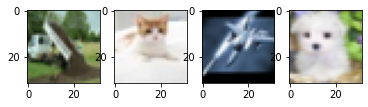

In [21]:
# Affichage des images originales
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(test[0][0][i])

In [22]:
(x_train_lab, y_train_lab), (x_train_unlab, y_train_unlab), (x_test, y_test) = generate_dataset(percent, random_state=31415)

if batch_size_lab < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size_lab)
else:
    steps_per_epoch = 1
    batch_size_lab = x_train_lab.shape[0]
    
# Nombre de pas d'entrainement
K = steps_per_epoch * epochs # 2**10 # 2**20


weak_augment = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    fill_mode='reflect'
)

strong_augment = iaa.RandAugment(n=2, m=15)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
#optimizer = keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4)
loss_s = keras.losses.CategoricalCrossentropy()

model = get_model()
model.compile(optimizer=optimizer,
              loss=loss_s,
              metrics=['accuracy'])

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()

In [23]:
''' 
Charger les poids de notre modèle 
'''
load_checkpoint = True
model_path = "models/fixmatch/random_images/"
if load_checkpoint:
    model.load_weights(f"{model_path}/{per_int}_percent")
    epochs = 1 # Just to verify model well trained 

    #Chargement de HISTORY 
    with open(f"{model_path}/{per_int}_percent_history.json", 'r') as file:
        history = json.load(file)
else:
    history = {"loss_sup": [], "loss_unsup": [], "loss_total": [], "acc": [], "test_acc": [], "nb_pseudo_label": []}

In [24]:
''' 
Précision avant (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 1.1554 - accuracy: 0.7329 - 2s/epoch - 6ms/step


[1.1554189920425415, 0.7329000234603882]

In [25]:
training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment)

[codecarbon INFO @ 22:24:59] [setup] RAM Tracking...
[codecarbon INFO @ 22:24:59] [setup] GPU Tracking...
[codecarbon INFO @ 22:24:59] No GPU found.
[codecarbon INFO @ 22:24:59] [setup] CPU Tracking...
[codecarbon WARNING @ 22:24:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:25:00] CPU Model on constant consumption mode: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 22:25:00] >>> Tracker's metadata:
[codecarbon INFO @ 22:25:00]   Platform system: Linux-5.19.0-45-generic-x86_64-with-glibc2.17
[codecarbon INFO @ 22:25:00]   Python version: 3.8.16
[codecarbon INFO @ 22:25:00]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 22:25:00]   Available RAM : 14.450 GB
[codecarbon INFO @ 22:25:00]   CPU count: 12
[codecarbon INFO @ 22:25:00]   CPU model: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 22:25:00]   GPU count: None
[codecarbon INFO @ 22:25:00]   GPU model: None
[codecarbon INFO @ 22:25:18] Energy consumed for RAM : 0.000

Epoch   0 : Accuracy = 0.9964, Test Accuracy = 0.7322,
	    Loss = 22.314, Nb Pseudo Labels = 22570 / 34944


In [26]:
''' 
Précision après (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 1.2390 - accuracy: 0.7322 - 2s/epoch - 6ms/step


[1.2390133142471313, 0.732200026512146]

In [27]:
save_model = False  
if save_model:
    model.save_weights(f"unsupervised/{per_int}_percent")

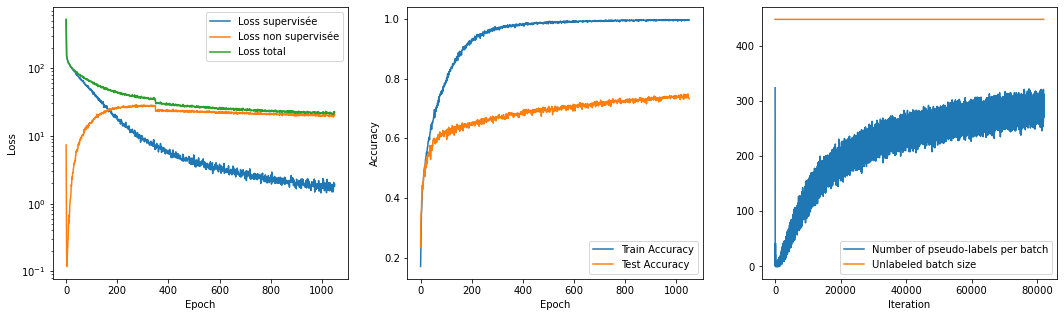

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.semilogy(history["loss_sup"])
plt.semilogy(history["loss_unsup"])
plt.semilogy(history["loss_total"])
plt.legend(["Loss supervisée", "Loss non supervisée", "Loss total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(history["acc"])
plt.plot(history["test_acc"])
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(133)
flattened = [item for sublist in history["nb_pseudo_label"] for item in sublist]
plt.plot(flattened)
plt.plot([batch_size_unlab]*len(flattened))
plt.legend(["Number of pseudo-labels per batch", "Unlabeled batch size"])
plt.xlabel("Iteration")
plt.show()

In [30]:
dict_class= {0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog', 
            7: 'horse', 
            8: 'ship', 
            9: 'truck'}            

313/313 [==============================] - 2s 6ms/step


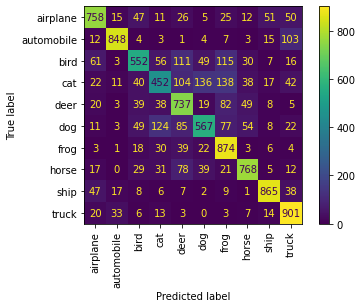

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dict_class.values())
disp.plot(xticks_rotation='vertical')
plt.show()

## Avec x% des données choisies   <a id="3_2"></a>

In [32]:
''' 
Importer les images uniques 
'''
unique_img_path = 'unique-cifar10-images/'

percent = 0.05
per_int = int(percent*100)

test = np.load(unique_img_path +f'X_unique_{per_int}.npy')
test_y = np.load(unique_img_path +f'y_unique_{per_int}.npy')
test_y = tf.keras.utils.to_categorical(test_y)

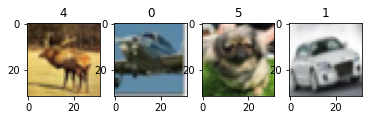

In [33]:
# Affichage des images originales
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(test[i])
    plt.title(test_y[i].argmax())

In [34]:
(x_train_lab, y_train_lab), (x_train_unlab, y_train_unlab), (x_test, y_test) = generate_dataset(sup_percent=0.1)

# Charger les images uniques 
x_train_lab, y_train_lab =  np.load(unique_img_path + f'X_unique_{per_int}.npy'), np.load(unique_img_path +f'y_unique_{per_int}.npy')
y_train_lab = tf.keras.utils.to_categorical(y_train_lab)

if batch_size_lab < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size_lab)
else:
    steps_per_epoch = 1
    batch_size_lab = x_train_lab.shape[0]
    
# Nombre de pas d'entrainement
K = steps_per_epoch * epochs # 2**10 # 2**20


weak_augment = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    fill_mode='reflect'
)

strong_augment = iaa.RandAugment(n=2, m=15)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
#optimizer = keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4)
loss_s = keras.losses.CategoricalCrossentropy()

model = get_model()
model.compile(optimizer=optimizer,
              loss=loss_s,
              metrics=['accuracy'])

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()

In [35]:
load_checkpoint = True
model_path = "models/fixmatch/unique_images/"
if load_checkpoint:
    model.load_weights(f"{model_path}/{per_int}_percent_unique")
    with open(f"{model_path}/{per_int}_percent_unique_history.json", 'r') as file:
        history = json.load(file)
    epochs = 1 # 2 
else:
    history = {"loss_sup": [], "loss_unsup": [], "loss_total": [], "acc": [], "test_acc": [], "nb_pseudo_label": []}

In [36]:
''' 
Précision avant (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 2.2552 - accuracy: 0.5811 - 2s/epoch - 7ms/step


[2.2552273273468018, 0.5810999870300293]

In [37]:
training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment)

[codecarbon INFO @ 22:28:20] [setup] RAM Tracking...
[codecarbon INFO @ 22:28:20] [setup] GPU Tracking...
[codecarbon INFO @ 22:28:20] No GPU found.
[codecarbon INFO @ 22:28:20] [setup] CPU Tracking...
[codecarbon WARNING @ 22:28:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:28:21] CPU Model on constant consumption mode: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 22:28:21] >>> Tracker's metadata:
[codecarbon INFO @ 22:28:21]   Platform system: Linux-5.19.0-45-generic-x86_64-with-glibc2.17
[codecarbon INFO @ 22:28:21]   Python version: 3.8.16
[codecarbon INFO @ 22:28:21]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 22:28:21]   Available RAM : 14.450 GB
[codecarbon INFO @ 22:28:21]   CPU count: 12
[codecarbon INFO @ 22:28:21]   CPU model: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 22:28:21]   GPU count: None
[codecarbon INFO @ 22:28:21]   GPU model: None


In [ ]:
''' 
Précision après (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 1.9598 - accuracy: 0.6026 - 2s/epoch - 8ms/step


[1.9597880840301514, 0.6025999784469604]

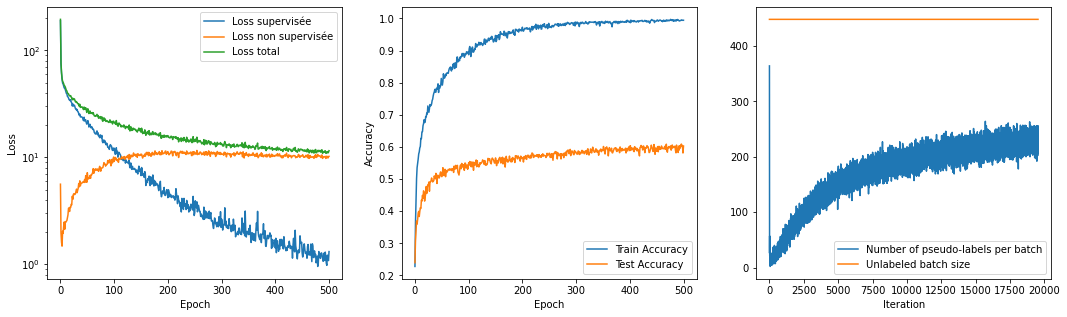

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.semilogy(history["loss_sup"])
plt.semilogy(history["loss_unsup"])
plt.semilogy(history["loss_total"])
plt.legend(["Loss supervisée", "Loss non supervisée", "Loss total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(history["acc"])
plt.plot(history["test_acc"])
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(133)
flattened = [item for sublist in history["nb_pseudo_label"] for item in sublist]
plt.plot(flattened)
plt.plot([batch_size_unlab]*len(flattened))
plt.legend(["Number of pseudo-labels per batch", "Unlabeled batch size"])
plt.xlabel("Iteration")
plt.show()

313/313 [==============================] - 2s 7ms/step


<Figure size 1080x1080 with 0 Axes>

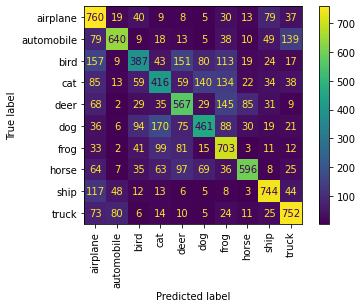

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dict_class.values())
disp.plot(xticks_rotation='vertical')
plt.show()